### Stanford 40

In [ ]:
from collections import Counter
from sklearn.model_selection import train_test_split

keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse", 
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]
with open('ImageSplits/train.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    train_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]

with open('ImageSplits/test.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    test_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]

# Combine the splits and split for keeping more images in the training set than the test set.
all_files = train_files + test_files
all_labels = train_labels + test_labels
train_files, test_files = train_test_split(all_files, test_size=0.1, random_state=0, stratify=all_labels)
train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]
print(f'Train files ({len(train_files)}):\n\t{train_files}')
print(f'Train labels ({len(train_labels)}):\n\t{train_labels}\n'\
      f'Train Distribution:{list(Counter(sorted(train_labels)).items())}\n')
print(f'Test files ({len(test_files)}):\n\t{test_files}')
print(f'Test labels ({len(test_labels)}):\n\t{test_labels}\n'\
      f'Test Distribution:{list(Counter(sorted(test_labels)).items())}\n')
action_categories = sorted(list(set(train_labels)))
print(f'Action categories ({len(action_categories)}):\n{action_categories}')

<h5>Create a validation set by sampling 10% of the training data with stratification</h5>

In [ ]:
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.1, random_state=0, stratify=train_labels)

<h5>Stanford 40 – Frames custom CNN training and evaluation pipeline</h5>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.optim.lr_scheduler import CyclicLR

# Define the path to the 'JPEGImages' folder
jpeg_folder = 'JPEGImages'

# Define the data transforms
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Choice task 1, this is with data augmentation:
# data_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Create a dictionary to map action categories to integer labels
action_to_idx = {action: idx for idx, action in enumerate(action_categories)}
# Create custom dataset
class Stanford40Dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, labels, jpeg_folder, transform=None):
        self.file_list = file_list
        self.labels = [action_to_idx[label] for label in labels]  # Convert labels to integers
        self.jpeg_folder = jpeg_folder
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_name = self.file_list[index]
        img_path = os.path.join(self.jpeg_folder, img_name)
        img = Image.open(img_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            img = self.transform(img)

        return img, label

# Create data loaders
train_dataset = Stanford40Dataset(train_files, train_labels, jpeg_folder, transform=data_transforms)
val_dataset = Stanford40Dataset(val_files, val_labels, jpeg_folder, transform=data_transforms)
test_dataset = Stanford40Dataset(test_files, test_labels, jpeg_folder, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the custom CNN architecture
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = CustomCNN(num_classes=len(action_categories)).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Choice task #3, cyclic learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=len(train_loader)*2, mode='triangular')

# Train the model
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Choice task 3
        scheduler.step()  # Update the learning rate

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_dataset)
    train_acc = train_acc.double() / len(train_dataset)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_dataset)
    val_acc = val_acc.double() / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

# Evaluate the model on the test set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_acc = 0.0
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_acc += torch.sum(preds == labels.data)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = test_acc.double() / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=action_categories, yticklabels=action_categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### HMDB51 – Frames (transfer learning)

In [70]:
import glob

TRAIN_TAG, TEST_TAG = 1, 2
train_files, test_files = [], []
train_labels, test_labels = [], []
split_pattern_name = f"*test_split1.txt"
split_pattern_path = os.path.join('test_train_splits', split_pattern_name)
annotation_paths = glob.glob(split_pattern_path)
keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse", 
        "run", "shoot_bow", "smoke", "throw", "wave"]
for filepath in annotation_paths:
    class_name = '_'.join(filepath.split('/')[-1].split('_')[:-2])
    if class_name not in keep_hmdb51:
        continue  # skipping the classes that we won't use.
    with open(filepath) as fid:
        lines = fid.readlines()
    for line in lines:
        video_filename, tag_string = line.split()
        tag = int(tag_string)
        if tag == TRAIN_TAG:
            train_files.append(video_filename)
            train_labels.append(class_name)
        elif tag == TEST_TAG:
            test_files.append(video_filename)
            test_labels.append(class_name)

print(f'Train files ({len(train_files)}):\n\t{train_files}')
print(f'Train labels ({len(train_labels)}):\n\t{train_labels}\n'\
      f'Train Distribution:{list(Counter(sorted(train_labels)).items())}\n')
print(f'Test files ({len(test_files)}):\n\t{test_files}')
print(f'Test labels ({len(test_labels)}):\n\t{test_labels}\n'\
      f'Test Distribution:{list(Counter(sorted(test_labels)).items())}\n')
action_categories = sorted(list(set(train_labels)))
print(f'Action categories ({len(action_categories)}):\n{action_categories}')

Train files (840):
	['20060723sfjffangelina_throw_u_cm_np1_ba_med_4.avi', '2008-08-09GiantsGameDodgersPracticeClaytonKershaw_throw_f_cm_np1_fr_med_0.avi', '2008-08-09GiantsGameDodgersPracticeClaytonKershaw_throw_f_cm_np1_fr_med_1.avi', '2008-08-09GiantsGameDodgersPracticeClaytonKershaw_throw_f_cm_np1_fr_med_2.avi', 'APOCALYPTO_throw_f_nm_np1_fr_med_1.avi', 'APOCALYPTO_throw_u_cm_np1_ri_med_0.avi', 'AdamandAlvonplayingbasketball2_throw_f_nm_np1_fr_med_1.avi', 'BaseballPitchingtarget_BaseballPitchingCage_throw_u_cm_np1_ba_med_1.avi', 'BaseballPitchingtarget_BaseballPitchingCage_throw_u_nm_np1_ba_med_0.avi', 'BiomechanicsEvaluationofaPitcher_throw_f_cm_np1_ri_med_0.avi', 'Compilationknifethrowing_throw_u_nm_np1_ba_med_0.avi', 'Compilationknifethrowing_throw_u_nm_np1_ba_med_1.avi', 'Compilationknifethrowing_throw_u_nm_np1_ba_med_10.avi', 'Compilationknifethrowing_throw_u_nm_np1_ba_med_11.avi', 'Compilationknifethrowing_throw_u_nm_np1_ba_med_12.avi', 'Compilationknifethrowing_throw_u_nm_np1

In [54]:
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.1, random_state=0, stratify=train_labels)

Epoch [1/10], Train Loss: 3.8439, Train Acc: 0.1655, Val Loss: 2.6921, Val Acc: 0.2619
Epoch [2/10], Train Loss: 2.7320, Train Acc: 0.2464, Val Loss: 2.0894, Val Acc: 0.3571
Epoch [3/10], Train Loss: 2.2052, Train Acc: 0.3488, Val Loss: 1.7261, Val Acc: 0.4167
Epoch [4/10], Train Loss: 1.8788, Train Acc: 0.4095, Val Loss: 1.4603, Val Acc: 0.4762
Epoch [5/10], Train Loss: 1.6313, Train Acc: 0.4857, Val Loss: 1.2323, Val Acc: 0.5833
Epoch [6/10], Train Loss: 1.4067, Train Acc: 0.5560, Val Loss: 1.0302, Val Acc: 0.7262
Epoch [7/10], Train Loss: 1.2096, Train Acc: 0.6417, Val Loss: 0.8412, Val Acc: 0.8095
Epoch [8/10], Train Loss: 1.0038, Train Acc: 0.7107, Val Loss: 0.6855, Val Acc: 0.8214
Epoch [9/10], Train Loss: 0.8244, Train Acc: 0.7940, Val Loss: 0.5414, Val Acc: 0.8690
Epoch [10/10], Train Loss: 0.6566, Train Acc: 0.8405, Val Loss: 0.4356, Val Acc: 0.9286
Test Accuracy on HMDB51: 0.2333


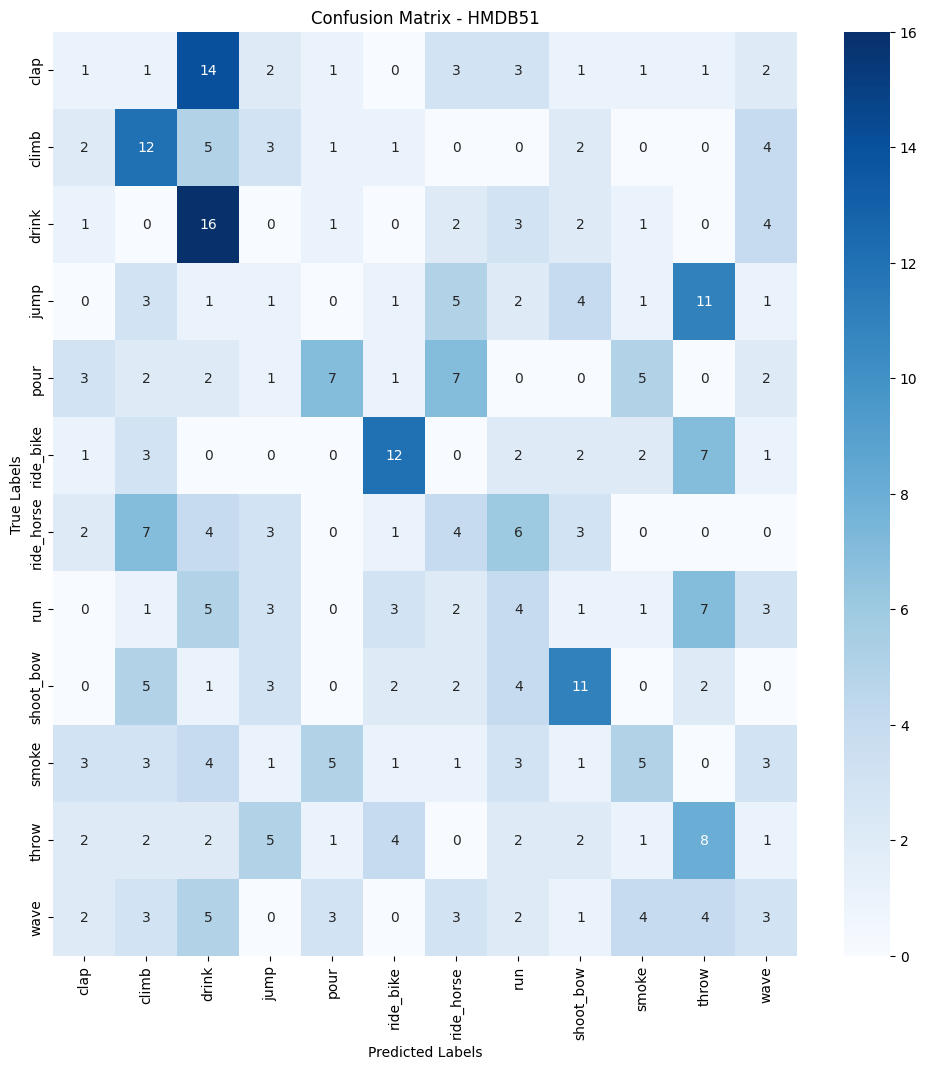

In [71]:
import cv2
import numpy as np


# Define the path to the 'video_data' folder
video_folder = 'video_data'

# Choice task 2
# data_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Create custom dataset for HMDB51
class HMDB51Dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, labels, video_folder, transform=None):
        self.file_list = file_list
        self.labels = [action_categories.index(label) for label in labels]  # Convert labels to integers
        self.video_folder = video_folder
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        video_name = self.file_list[index]
        label = self.labels[index]
        class_name = action_categories[label]
        video_path = os.path.join(self.video_folder, class_name, video_name)
        video = cv2.VideoCapture(video_path)
        frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        middle_frame_idx = frame_count // 2
        video.set(cv2.CAP_PROP_POS_FRAMES, middle_frame_idx)
        ret, frame = video.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            if self.transform:
                frame = self.transform(frame)
        else:
            raise ValueError(f"Failed to read middle frame from video: {video_path}")
        return frame, label

# Create data loaders for HMDB51
train_hmdb51_dataset = HMDB51Dataset(train_files, train_labels, video_folder, transform=data_transforms)
val_hmdb51_dataset = HMDB51Dataset(val_files, val_labels, video_folder, transform=data_transforms)
test_hmdb51_dataset = HMDB51Dataset(test_files, test_labels, video_folder, transform=data_transforms)

train_hmdb51_loader = DataLoader(train_hmdb51_dataset, batch_size=32, shuffle=True)
val_hmdb51_loader = DataLoader(val_hmdb51_dataset, batch_size=32, shuffle=False)
test_hmdb51_loader = DataLoader(test_hmdb51_dataset, batch_size=32, shuffle=False)

# Load the pretrained model
pretrained_model = CustomCNN(num_classes=len(action_categories))
pretrained_model.load_state_dict(torch.load('best_model.pth'))
pretrained_model = pretrained_model.to(device)

# Fine-tune the pretrained model on HMDB51
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.0001)  # Use a smaller learning rate for fine-tuning

# Choice task 3
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, step_size_up=len(train_hmdb51_loader) * 2, mode='triangular')

num_epochs = 10
best_val_acc = 0.0
for epoch in range(num_epochs):
    pretrained_model.train()
    train_loss = 0.0
    train_acc = 0.0
    for images, labels in train_hmdb51_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = pretrained_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)
        
        # Choice task 3
        scheduler.step()
    train_loss = train_loss / len(train_hmdb51_dataset)
    train_acc = train_acc.double() / len(train_hmdb51_dataset)

    pretrained_model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for images, labels in val_hmdb51_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = pretrained_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)
    val_loss = val_loss / len(val_hmdb51_dataset)
    val_acc = val_acc.double() / len(val_hmdb51_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(pretrained_model.state_dict(), 'best_hmdb51_model.pth')

# Evaluate the fine-tuned model on the HMDB51 test set
pretrained_model.load_state_dict(torch.load('best_hmdb51_model.pth'))
pretrained_model.eval()
test_acc = 0.0
test_preds = []
test_labels = []
with torch.no_grad():
    for images, labels in test_hmdb51_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = pretrained_model(images)
        _, preds = torch.max(outputs, 1)
        test_acc += torch.sum(preds == labels.data)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
test_acc = test_acc.double() / len(test_hmdb51_dataset)
print(f"Test Accuracy on HMDB51: {test_acc:.4f}")

# Plot confusion matrix for HMDB51
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=action_categories, yticklabels=action_categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - HMDB51')
plt.show()